<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load data</a></span></li></ul></li><li><span><a href="#Undersampling-techniques" data-toc-modified-id="Undersampling-techniques-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Undersampling techniques</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Label-encoding-for-categorical-variable" data-toc-modified-id="Label-encoding-for-categorical-variable-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span><strong>Label encoding for categorical variable</strong></a></span></li><li><span><a href="#Count-encoding-for-categorical-variables" data-toc-modified-id="Count-encoding-for-categorical-variables-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Count encoding for categorical variables</a></span></li></ul></li></ul></li><li><span><a href="#Oversampling-techniques" data-toc-modified-id="Oversampling-techniques-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Oversampling techniques</a></span></li></ul></div>

# Bank Marketing Undersampling


We've seen the bank marketing dataset is an imbalanced data which means that datasets have many more instances of certain classes than of others, so we need to deal with this very carefully. 

> __Why is imbalanced dataset problem?__
    - Most machine learning algorithms assume balanced distributions. As the minority examples occur rarely, rules to predict the small classes are difficult to find. Samples from the minority class are most often misclassified. 
    
    
> __What is Under-Sampling methods?__
    - Undersampling methods process of __reducing__ the number of samples from the majority class. 
    
There is no consensus in the community regarding which technique should be used with imbalanced datsets. 
Therefore, in this notebook, I will compare the performances of different undersampling techniques and choose which one is the best for the bank marketing dataset.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pathlib import Path
import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/BankMarketing'

In [3]:
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/BankMarketing')

In [4]:
# for the model 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix
)

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import encoding as ce

# for undersampling
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

### Load data

In [5]:
data = pd.read_csv(path/'cleaned_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
print(data.shape)
data.head()

(41185, 21)


,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,pdays_group
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,51-60,Not contacted
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,51-60,Not contacted
2,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,31-40,Not contacted
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,31-40,Not contacted
4,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,51-60,Not contacted


In [6]:
# create lists of numerical and categorical variables
cat_vars = [var for var in data.columns if data[var].dtype == 'O' and var != 'y']
num_vars = [var for var in data.columns if data[var].dtype != 'O' and var != 'y']

print('The number of categorical variables: {}'.format(len(cat_vars)))
print('The number of numerical variables: {}'.format(len(num_vars)))

The number of categorical variables: 12
The number of numerical variables: 8


In [44]:
def run_RFs(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=39)
    rf.fit(X_train, y_train)
    
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))
    #print('Confusion_matrix: ')
    #print(confusion_matrix(y_train, rf.predict(X_train)))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    #print('Confusion_matrix: ')
    #print(confusion_matrix(y_test, rf.predict(X_test)))
    
    return roc_auc_score(y_test, pred[:, 1])

In [13]:
def run_logit(X_train, X_test, y_train, y_test):
    logit = LogisticRegression(C=0.01, max_iter=1000, random_state=44)
    logit.fit(X_train, y_train)
    
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))
    #print('Confusion_matrix: ')
    #print(confusion_matrix(y_train, logit.predict(X_train)))
    
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    #print('Confusion_matrix: ')
    #print(confusion_matrix(y_test, logit.predict(X_test)))

## Undersampling techniques

    RandomSampling
    CondensedNearestNeighbour,- takes a lot of time
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours, - takes a lot of time
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
    
    
While performing trial and error, cnn and renn took so long time to perform, so I didn't include them after I got an error. Also, both methods did not improve the performances. 

Also, I realized when I tried to see the differences between categorical encoding methods, both performances look similar (or exactly same) when I used undersampling techniques. So, I will use only label encoding for further experiments. 

In [48]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=1),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=1),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=1),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=1),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=1),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=1),
   
    'iht_RF': InstanceHardnessThreshold(
        estimator=RandomForestClassifier(n_estimators=30, max_depth=3, random_state=39),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=1,
        cv=3
    ),
    
    'iht_logit': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=1,
        cv=3
    )
    
}

#### __Label encoding for categorical variable__

In [49]:
# loop to train models with the different under-sampling methods

# to save the results
results_dict = {}
shapes_dict = {}

# separate train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('y', axis=1), 
    data['y'],
    test_size=0.3,
    random_state=0
)

# label encoding for categorical variables
ordinal_enc = ce.OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_vars
)

ordinal_enc.fit(X_train)
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

# set up the scaler for feature scaling because we have KNN based techniques
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

y_train = y_train.map({'no':0, 'yes': 1})
y_test = y_test.map({'no': 0, 'yes': 1})



# train a model on the original data without under-sampling
# and determine model performance
roc = run_RFs(X_train, X_test, y_train, y_test)

# store results
results_dict['full_data'] = roc
shapes_dict['full_data'] = len(X_train)

print()

# now, we test the different under-samplers
for undersampler in undersampler_dict.keys():
    
    print(undersampler)
    
    # resample the train set only
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    # train model and evaluate performance
    
    # Note that performance returned is using test set, 
    # which was not under-sampled
    
    roc = run_RFs(X_resampled, X_test, y_resampled, y_test)
    
    # store results
    results_dict[undersampler] = roc
    shapes_dict[undersampler] = len(X_resampled)
    
    print()
    
print()

Train set
Random Forests roc-auc: 0.9277391477348833
Test set
Random Forests roc-auc: 0.9301929165098902

random
Train set
Random Forests roc-auc: 0.918630886370392
Test set
Random Forests roc-auc: 0.9190900933678943

tomek
Train set
Random Forests roc-auc: 0.9356610485018332
Test set
Random Forests roc-auc: 0.928639737583096

oss
Train set
Random Forests roc-auc: 0.9367623339431852
Test set
Random Forests roc-auc: 0.9293732933607022

enn
Train set
Random Forests roc-auc: 0.9673882908150533
Test set
Random Forests roc-auc: 0.92669505788196

allknn
Train set
Random Forests roc-auc: 0.9723198833543294
Test set
Random Forests roc-auc: 0.9249251240308828

nm1
Train set
Random Forests roc-auc: 0.8866529730101812
Test set
Random Forests roc-auc: 0.8487124995471879

nm2
Train set
Random Forests roc-auc: 0.9298391000064792
Test set
Random Forests roc-auc: 0.56201041745716

iht_RF
Train set
Random Forests roc-auc: 0.997656679795455
Test set
Random Forests roc-auc: 0.8105648888488152

iht_logit


In [50]:
results_dict

{'full_data': 0.9301929165098902,
 'random': 0.9190900933678943,
 'tomek': 0.928639737583096,
 'oss': 0.9293732933607022,
 'enn': 0.92669505788196,
 'allknn': 0.9249251240308828,
 'nm1': 0.8487124995471879,
 'nm2': 0.56201041745716,
 'iht_RF': 0.8105648888488152,
 'iht_logit': 0.8536468305392947}

In [51]:
shapes_dict

{'full_data': 28829,
 'random': 6522,
 'tomek': 28012,
 'oss': 28010,
 'enn': 25429,
 'allknn': 24963,
 'nm1': 6522,
 'nm2': 6522,
 'iht_RF': 6528,
 'iht_logit': 6522}

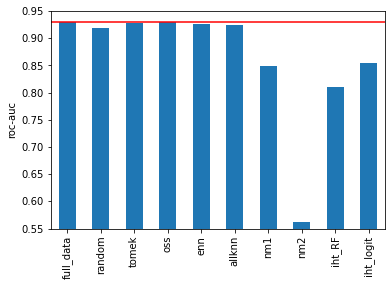

In [54]:
pd.Series(results_dict).plot.bar()
plt.ylabel('roc-auc')
plt.ylim(0.55, 0.95)
plt.axhline(results_dict['full_data'], color='r')
plt.show()

None of the different techniques improved performances compared to the baseline model. 

#### Count encoding for categorical variables

In [55]:
# loop to train models with the different under-sampling methods

# to save the results
results_dict_count = {}
shapes_dict_count = {}

# separate train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('y', axis=1), 
    data['y'],
    test_size=0.3,
    random_state=0
)

# label encoding for categorical variables
ordinal_enc = ce.OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_vars
)

ordinal_enc.fit(X_train)
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

# set up the scaler for feature scaling because we have KNN based techniques
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

y_train = y_train.map({'no':0, 'yes': 1})
y_test = y_test.map({'no': 0, 'yes': 1})



# train a model on the original data without under-sampling
# and determine model performance
roc = run_RFs(X_train, X_test, y_train, y_test)

# store results
results_dict_count['full_data'] = roc
shapes_dict_count['full_data'] = len(X_train)

print()

# now, we test the different under-samplers
for undersampler in undersampler_dict.keys():
    
    print(undersampler)
    
    # resample the train set only
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
    
    # train model and evaluate performance
    
    # Note that performance returned is using test set, 
    # which was not under-sampled
    
    roc = run_RFs(X_resampled, X_test, y_resampled, y_test)
    
    # store results
    results_dict_count[undersampler] = roc
    shapes_dict_count[undersampler] = len(X_resampled)
    
    print()
    
print()

Train set
Random Forests roc-auc: 0.9277391477348833
Test set
Random Forests roc-auc: 0.9301929165098902

random
Train set
Random Forests roc-auc: 0.918630886370392
Test set
Random Forests roc-auc: 0.9190900933678943

tomek
Train set
Random Forests roc-auc: 0.9356610485018332
Test set
Random Forests roc-auc: 0.928639737583096

oss
Train set
Random Forests roc-auc: 0.9367623339431852
Test set
Random Forests roc-auc: 0.9293732933607022

enn
Train set
Random Forests roc-auc: 0.9673882908150533
Test set
Random Forests roc-auc: 0.92669505788196

allknn
Train set
Random Forests roc-auc: 0.9723198833543294
Test set
Random Forests roc-auc: 0.9249251240308828

nm1
Train set
Random Forests roc-auc: 0.8866529730101812
Test set
Random Forests roc-auc: 0.8487124995471879

nm2
Train set
Random Forests roc-auc: 0.9298391000064792
Test set
Random Forests roc-auc: 0.56201041745716

iht_RF
Train set
Random Forests roc-auc: 0.997656679795455
Test set
Random Forests roc-auc: 0.8105648888488152

iht_logit


In [57]:
# used integer encoding for categorical variables
results_dict

{'full_data': 0.9301929165098902,
 'random': 0.9190900933678943,
 'tomek': 0.928639737583096,
 'oss': 0.9293732933607022,
 'enn': 0.92669505788196,
 'allknn': 0.9249251240308828,
 'nm1': 0.8487124995471879,
 'nm2': 0.56201041745716,
 'iht_RF': 0.8105648888488152,
 'iht_logit': 0.8536468305392947}

In [56]:
# used count encoding for categorical variables
results_dict_count

{'full_data': 0.9301929165098902,
 'random': 0.9190900933678943,
 'tomek': 0.928639737583096,
 'oss': 0.9293732933607022,
 'enn': 0.92669505788196,
 'allknn': 0.9249251240308828,
 'nm1': 0.8487124995471879,
 'nm2': 0.56201041745716,
 'iht_RF': 0.8105648888488152,
 'iht_logit': 0.8536468305392947}

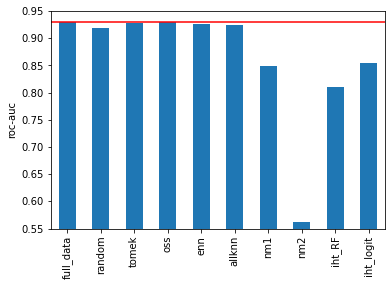

In [58]:
pd.Series(results_dict_count).plot.bar()
plt.ylabel('roc-auc')
plt.ylim(0.55, 0.95)
plt.axhline(results_dict_count['full_data'], color='r')
plt.show()

Regardless of methods for feature engineering for categorical variables, none of undersampling techniques did not improve the performances compared to original model. 

However, __RandomUndersampling__ method is the best for this dataset if we choose one of the oversampling methods, because it shows slightly improved performances compared to train (0.918) and test set(0.919). The other methods showed over-fitting. 

## Oversampling techniques